In [162]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm
from tbats import TBATS

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from prophet import Prophet

In [62]:
us_data = pd.read_csv('US_Data_Series.csv')
us_data['Date'] = pd.to_datetime(us_data['Date'])
us_data['year'] = us_data['Date'].dt.year
us_data['month'] = us_data['Date'].dt.month
us_data.set_index(['year', 'month'], inplace=True)
us_data.index = pd.to_datetime(us_data.index.map(lambda x: f'{x[0]}-{x[1]}-01'))

us_retail_sales = us_data[['US Retail Sales']].dropna()
us_retail_sales.head()

,US Retail Sales
1992-01-01,164095.0
1992-02-01,164213.0
1992-03-01,163721.0
1992-04-01,164709.0
1992-05-01,165612.0


To perform a decomposition:

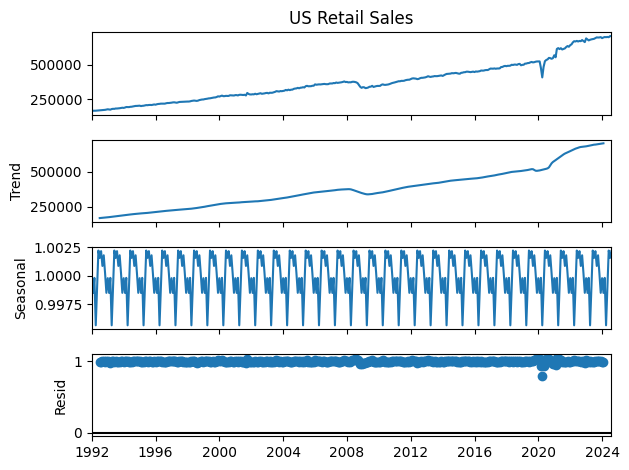

In [63]:
result = seasonal_decompose(us_retail_sales['US Retail Sales'], model='multiplicative', period = 12)
result.plot()
plt.show()

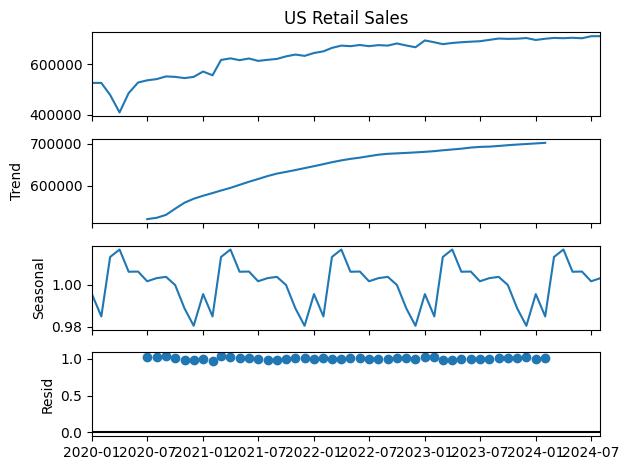

In [74]:
us_retail_sales_2020 = us_retail_sales['US Retail Sales'].loc['2020-01-01':]

result_2020 = seasonal_decompose(us_retail_sales_2020, model='multiplicative', period = 12)
result_2020.plot()
plt.show()

Now to determind d and D and check the ACF and PACF:

In [165]:
print('ADF Statistic:', adfuller(us_retail_sales_2020)[0])
print('p-value:', adfuller(us_retail_sales_2020)[1])

ADF Statistic: -4.1937097651629225
p-value: 0.0006752422644115984


<Axes: >

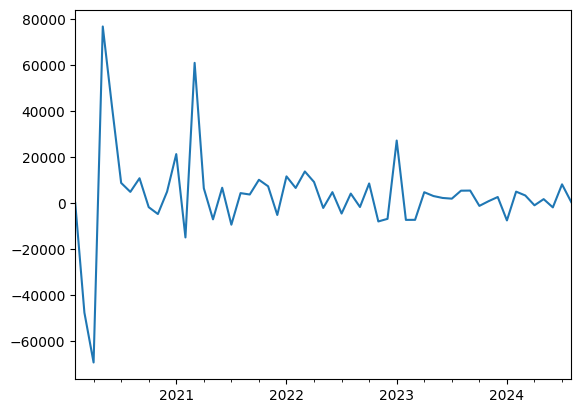

In [179]:
us_retail_sales_2020.diff().dropna().plot()

<Axes: >

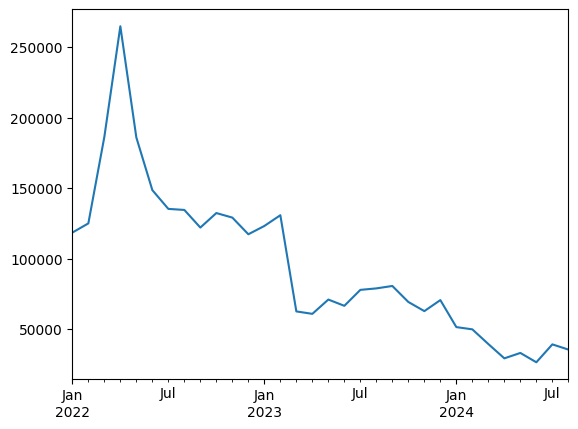

In [190]:
us_retail_sales_2020.diff(24).dropna().plot()

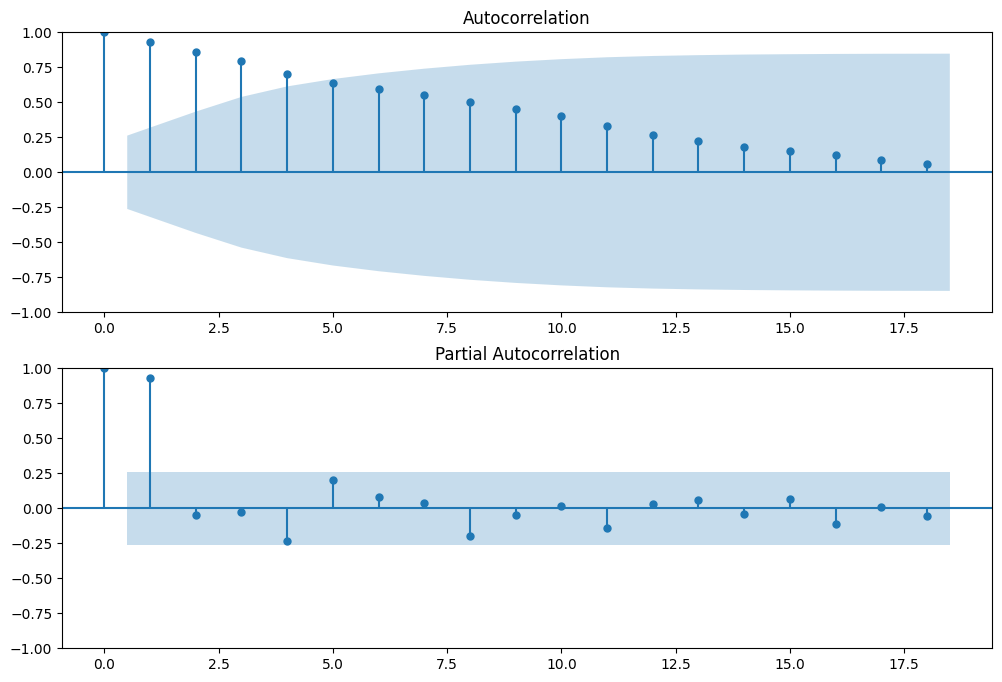

In [185]:
fig, ax=plt.subplots(2, figsize=(12,8))
plot_acf(us_retail_sales_2020, ax=ax[0])
plot_pacf(us_retail_sales_2020, ax=ax[1])
plt.show()

Now to compare different models.

For the classical ARIMA:

In [191]:
modelARIMA = pm.auto_arima(us_retail_sales_2020, seasonal=True, m=12, trace=False, max_order=None, stepwise=True, p=1, q=4, P=1, D=2)
print(modelARIMA.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                   56
Model:             SARIMAX(1, 0, 4)x(2, 2, [1], 12)   Log Likelihood                -344.223
Date:                              Thu, 10 Oct 2024   AIC                            706.446
Time:                                      01:44:00   BIC                            719.637
Sample:                                  01-01-2020   HQIC                           710.818
                                       - 08-01-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9895      0.064     15.570      0.000       0.865       1.114
ma.L1          0.00

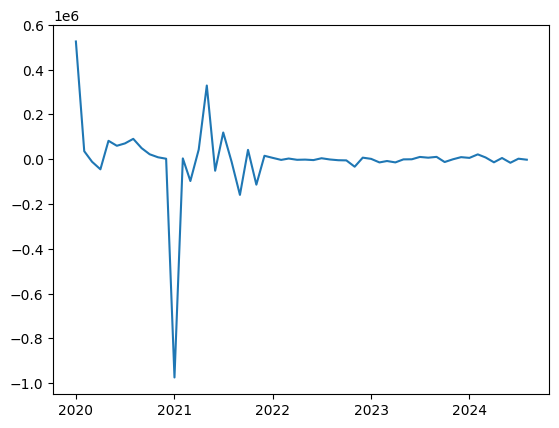

In [192]:
plt.plot(modelARIMA.resid())
plt.show()

In [193]:
forecastARIMA = modelARIMA.predict(n_periods=12)
print(forecastARIMA)

2024-09-01    719951.426470
2024-10-01    712229.174007
2024-11-01    719334.968923
2024-12-01    718145.238478
2025-01-01    678576.241988
2025-02-01    686963.962500
2025-03-01    687656.261928
2025-04-01    690624.670122
2025-05-01    690235.688013
2025-06-01    685345.133963
2025-07-01    696471.630826
2025-08-01    697321.189687
Freq: MS, dtype: float64


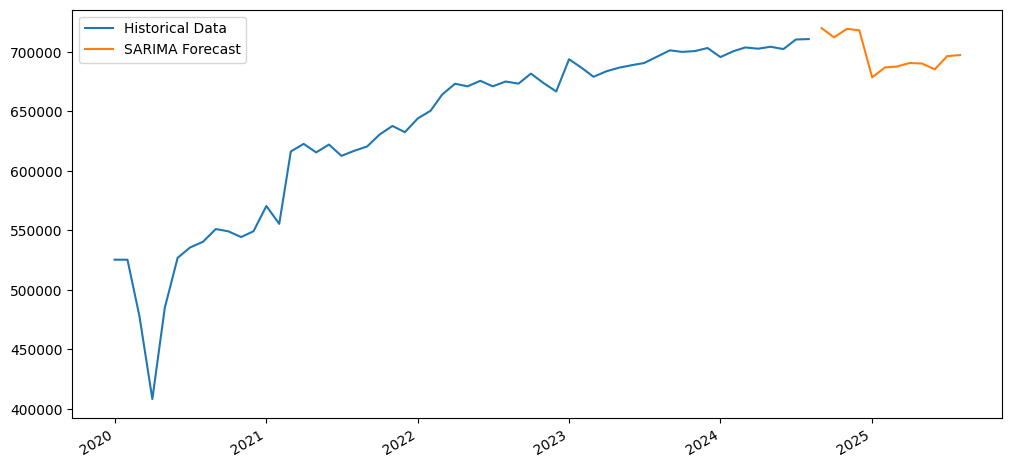

In [194]:
plt.figure(figsize=(12, 6))
plt.plot(us_retail_sales_2020, label='Historical Data')
forecastARIMA.plot(label='SARIMA Forecast')
plt.legend()
plt.show()

For the Prophet model:

In [131]:
us_retail_sales_2020_prophet = pd.DataFrame({
    'ds': us_retail_sales_2020.index,
    'y': us_retail_sales_2020.values
})

modelProphet = Prophet()
modelProphet.fit(us_retail_sales_2020_prophet)
future = modelProphet.make_future_dataframe(periods=12, freq='M')
forecastProphet = modelProphet.predict(future)
print(forecastProphet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12))

00:43:58 - cmdstanpy - INFO - Chain [1] start processing
00:43:58 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper
56 2024-08-31  717753.583313  697411.681169  738132.722642
57 2024-09-30  720093.197129  699833.879037  742090.957262
58 2024-10-31  714201.078218  694228.870071  736528.265946
59 2024-11-30  705034.594517  685279.736819  724984.345094
60 2024-12-31  731841.781034  710709.332307  752869.662615
61 2025-01-31  730826.227178  709855.667211  751887.390374
62 2025-02-28  693717.563462  672094.430698  714864.462669
63 2025-03-31  749147.032175  728122.274813  771049.792601
64 2025-04-30  723482.635142  701720.982191  745605.103209
65 2025-05-31  723254.634142  701307.022259  745247.616167
66 2025-06-30  724076.091918  702653.376439  746013.489800
67 2025-07-31  736956.415257  715280.524340  759276.821601


/opt/anaconda3/lib/python3.11/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


Text(0.5, 1.0, 'Residuals')

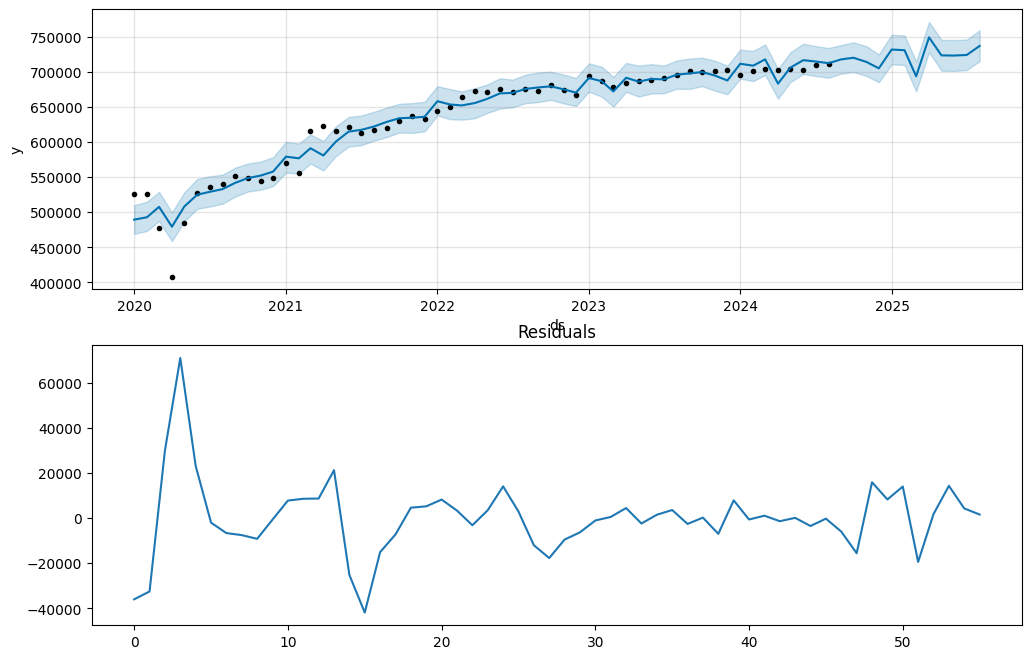

In [225]:
fig, ax = plt.subplots(2, figsize=(12, 8))
modelProphet.plot(forecastProphet, ax=ax[0])
ax[1].plot(forecastProphet.head(56)['yhat']-us_retail_sales_2020.values)
ax[1].set_title('Residuals')

For the `tbats` model:

In [203]:
modelTBATS = TBATS(seasonal_periods=[12, 2], use_trend=True).fit(us_retail_sales_2020)
forecastTBATS = modelTBATS.forecast(steps=12)
print(forecastTBATS)

[716348.56439556 721020.6842218  721173.89187629 721327.09953074
 721480.30718516 721633.51483955 721786.72249392 721939.93014825
 722093.13780256 722246.34545684 722399.55311109 722552.7607653 ]


/var/folders/tl/3k436bpn4w7328qlykmvjq3m0000gn/T/ipykernel_48741/2959509215.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecastTBATS.set_index(pd.date_range(start='2024-09-01', periods=12, freq='M'), inplace=True)


<Axes: >

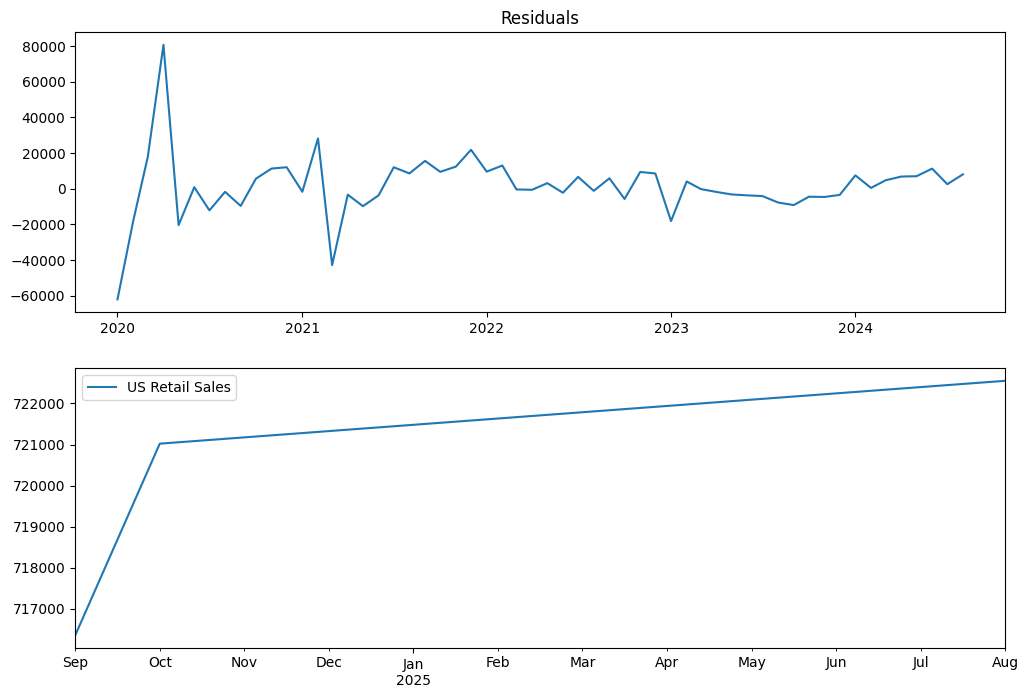

In [219]:
fig, ax=plt.subplots(2, figsize=(12,8))
ax[0].plot(modelTBATS.y_hat-us_retail_sales_2020)
ax[0].set_title('Residuals')
forecastTBATS = pd.DataFrame(forecastTBATS, columns=['US Retail Sales'])
forecastTBATS.set_index(pd.date_range(start='2024-09-01', periods=12, freq='M'), inplace=True)
forecastTBATS.plot(ax=ax[1])